# Project 1
from Artem Opperman's course: Deep Learning for Predictive Analytics

## 0 Importing `tensorflow-gpu==1.14`

- Artem's course uses Tensorflow 1.13
- As of 19th August 2019, Tensorflow 2.0 has been released
- The methods and classes used in this notebook are from Tensorflow 1.14

In [1]:
import tensorflow as tf
from IPython.display import clear_output

tf.__version__

'1.14.0'

## 1 Problem statement discussion


The project is based on the dataset used by Moro et al., 2014 <sup>[[1]](http://dx.doi.org/10.1016/j.dss.2014.03.001)</sup> in their publication: _S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems_

---

The publication's abstract provides the problem statement for us: " ***...to predict the success of telemarketing calls for selling bank long-term deposits***."

---


The dataset has 20 variables (predictive features) for the target variable $y$ which is defined as the answer to the binary question: has the client subscribed a term deposit?
The dataset is based on "Bank Marketing" UCI dataset. <sup>[[2]](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing)</sup>The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country, published by the Banco de Portugal and publicly available<sup>[[3]](https://www.bportugal.pt/estatisticasweb)</sup> online. Please note that the version of the dataset used for the project is not the same as the one used by Moro et.al. 2014. It does not include all attributes due to privacy concerns.
<br>
<br>
The original dataset actually had 150 features with bank client, product and social-economic attributes. A semi-automatic feature selection was explored in the modeling phase, performed with the data prior to July 2012 and that allowed to select a reduced set of 22 features. We will be working with this reduced version.
<br>
<br>

The zip file provided by Artem includes two fles:
 - `bank-additional-full.csv` with all examples, ordered by date (from May 2008 to November 2010).
 - `dataset_info.txt` which answers most of the questions relevant to descriptive analysis of the dataset.
 
 ---
***The binary classification goal, as specified by the instructor, is to predict if the client will subscribe a bank term deposit***

## 2 Extracting the dataset


In [2]:
# In case it needs to be downloaded during notebook execution

import urllib.request

!rm -rf *.rar
download_URL = "https://www.filepicker.io/api/file/rAA6HuWARrOrIGOVzpiE"
urllib.request.urlretrieve(download_URL, "datasets.rar")

('datasets.rar', <http.client.HTTPMessage at 0x7fcee70f5190>)

In [3]:
!ls

datasets.rar  Predictive_Behavior_Modelling.ipynb  start_server.sh


In [4]:
# `patool` can extract WINRAR archives
# you may need to install `unrar` executable for patool.extract_archive to work in this cell
# command for apt: `sudo apt-get install unrar`
#!pip install patool

import patoolib

# in case the archive has already been extracted from a previous iteration
!rm -rf dataset

patoolib.extract_archive("./datasets.rar", outdir = "./")
clear_output()

In [5]:
!ls dataset

bank_full.csv  dataset_info.txt


## 3 EDA

The sole objective for performing this step is to obtain a parsimonious set of explanatory variables

In [6]:
# you may need to install swifter as `pip install swifter`

import pandas as pd
from swifter import swifter
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

clear_output()

In [7]:
df = pd.read_csv("./dataset/bank_full.csv", sep = ";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### 3.1 Understanding variable dependencies


`dataset_info.txt` provides descriptions for the columns in `df`:

***Client information***

- age
- job : type of job 
- marital : marital status
- education
- default: has credit in default?
- housing: has housing loan?
- loan: has personal loan?

***Related with the last contact of the current campaign***

- contact: contact communication type
- month: last contact month of year
- day_of_week
- duration: last contact duration, in seconds (numeric). 


(Note:  the attribute `duration` highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model)

***Other attributes***

- campaign: number of contacts performed during this campaign and for this client
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign

***Social and economic context attributes***

- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)     
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

In [9]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Might as well seperate the variables based on whether they are categorical or not. I intend to one-hot encode them using dummy variables

In [10]:
categorical_variables = []
numeric_variables = []

for variable, dtype in zip(df.columns, df.dtypes):
    if dtype == "object":
        if variable != "y":
            # the target response is not a part of the analysis
            categorical_variables.append(variable)
    else:
        numeric_variables.append(variable)

In [11]:
print(categorical_variables)
print(numeric_variables)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### 3.2 Explanability heatmaps

- $R$ = coefficient of correlation between two variables $x_i$ and $x_j$
- $R^2$ = strength of correlation between $x_i$ and $x_j$
- $100.R^2$ = how much of target variable $x_i$ is explained by $x_j$ expressed as a percentage 

#### 3.2.1 Amongst numeric variables

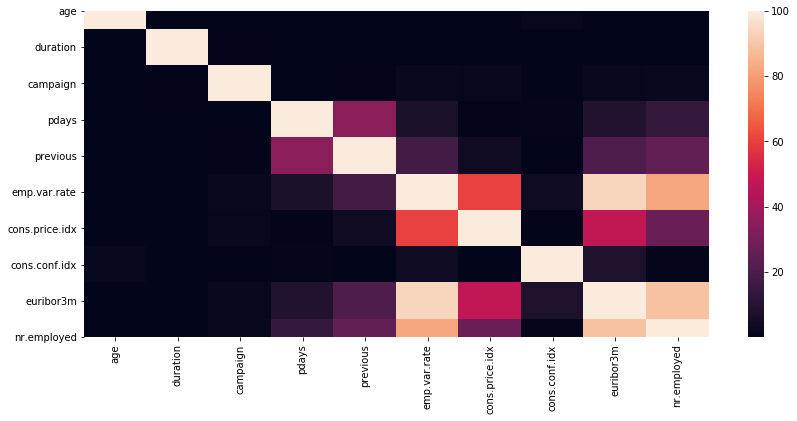

In [12]:
correlation_matrix = df[numeric_variables].corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 14, 6
plt.tight_layout()

sns.heatmap(explanability_matrix, xticklabels = numeric_variables, yticklabels = numeric_variables)
plt.show()

In [13]:
upper = explanability_matrix.where(np.triu(np.ones(explanability_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 75)]
to_drop

['euribor3m', 'nr.employed']

***Observations from the above heatmap between numeric variables***

- Age, Previous duration of campaign contact, and the number of campaigns when a client was contacted do not explain any variance of the other variables
- The number of employees a client has had quaterly strongly correlates with and explains a considerable amount of variability for quaterly employment variability rate, euribor 3 month rate and the consumer price index
- Quarterly Consumer Confidence doesn't correlate with any other variable.

<br>

***Aiming for the parsimonious model based on numeric variables only***

A parsimonious model is essentially a result of Occam's Razor. The principle is to obtain a model that has the lowest number of predictor variables with the maximum predictive power for the response variable. Having analyzed the heatmap, I decided to remove the following variables because they are explainable by more than `75%` by other variables.

- `euribor3m`
- `nr.employed`

#### 3.2.2 numeric variables ~ client job role

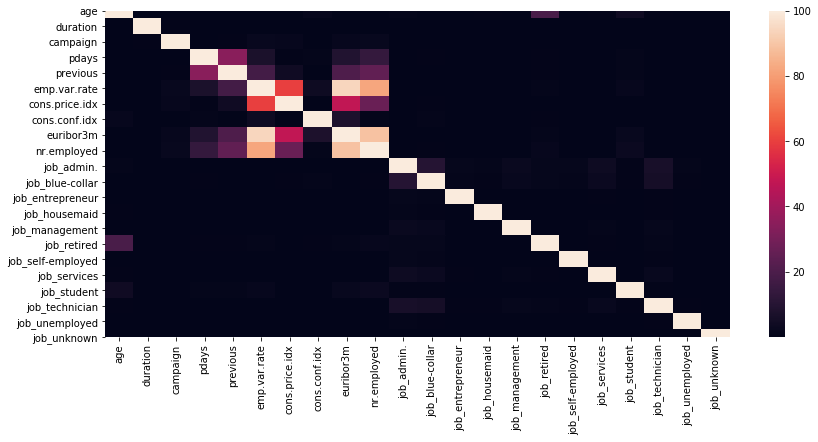

In [14]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["job"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 14, 6
plt.tight_layout()

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the job kind the client has***

- There's none. No variable can be explained by the specific kind of job a client has.

<br>

#### 3.2.3 numeric variables ~ client's maritial status

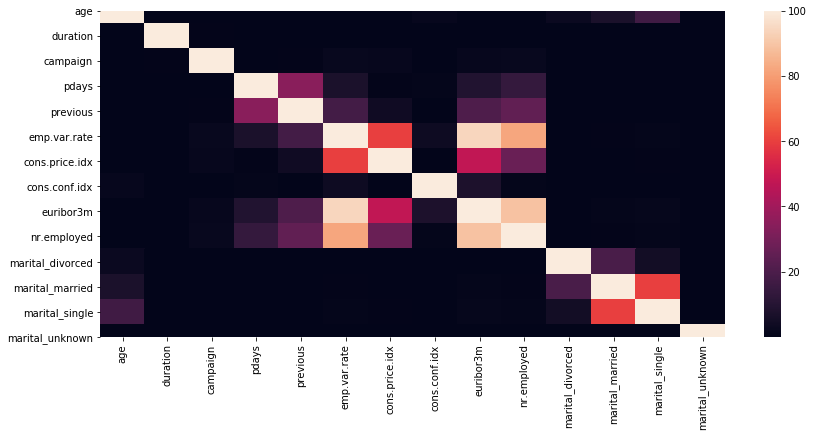

In [15]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["marital"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 14, 6
plt.tight_layout()

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the the client's martial status***

- There's none. No variable can be explained by the client's maritial status

<br>

#### 3.2.4 numeric variables ~ client's education qualification

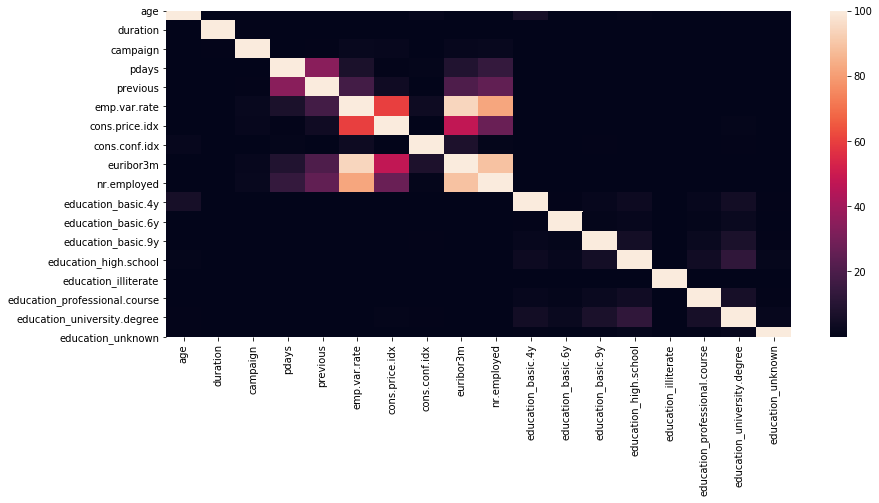

In [16]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["education"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 14, 6
plt.tight_layout()

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the the client's education qualifiation***

- There's none. No variable can be explained by the client's education qualification

<br>

#### 3.2.5 numeric variables ~ client's credit card's default status

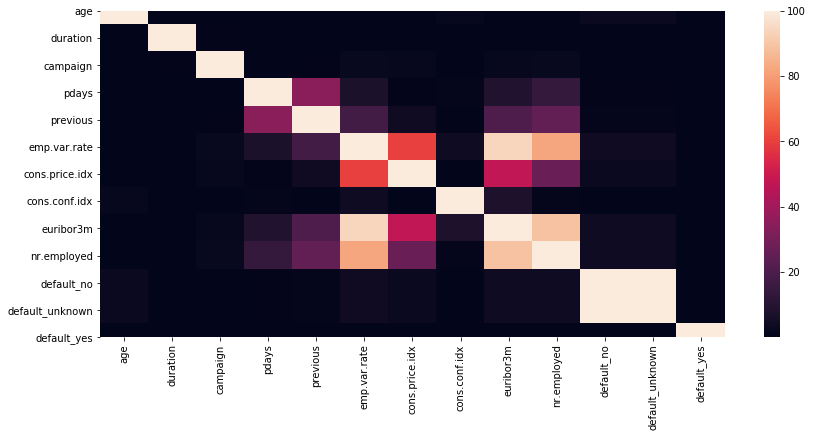

In [17]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["default"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 14, 6
plt.tight_layout()

sns.heatmap(explanability_matrix)
plt.show()

In [18]:
upper = explanability_matrix.where(np.triu(np.ones(explanability_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 75)]
to_drop

['euribor3m', 'nr.employed', 'default_unknown']

***Observations from the above heatmap between numeric variables and the the client's credit card default status***

- There's none. No variable can be explained by the client's credit card default status
- `default_unknown` is strongly correlated with `default_no`.




<br>

***Aiming for the parsimonious model***

I decided to remove the following variable because they are explainable by more than 75% by other variables.

- `default_unknown`

<br>

#### 3.2.6 numeric variables ~ the default status of the client's loan statuses

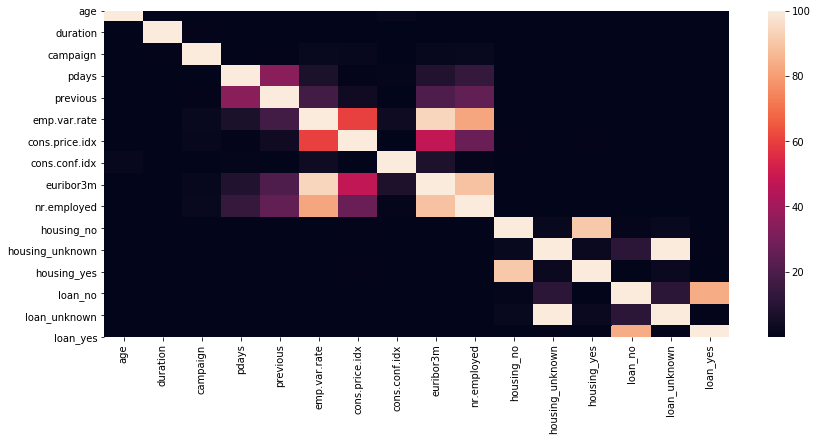

In [19]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["housing", "loan"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 14, 6
plt.tight_layout()

sns.heatmap(explanability_matrix)
plt.show()

In [20]:
upper = explanability_matrix.where(np.triu(np.ones(explanability_matrix.shape), k = 1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 75)]
to_drop

['euribor3m', 'nr.employed', 'housing_yes', 'loan_unknown', 'loan_yes']

***Observations from the above heatmap between numeric variables and the the client's loan statuses***

- If we are uncertain about the client's housing loan status, so are we about his/her personal loan status and vice versa



<br>

***Aiming for the parsimonious model***

I decided to remove the following variable because they are explainable by more than 75% by other variables.

- `housing_yes`
- `loan_unknown`
- `loan_yes`

### 3.3 Removing dependencies

In [21]:
df_encoded = pd.get_dummies(data = df, columns = categorical_variables)
df_encoded.drop(to_drop, axis = 1, inplace = True)
df_encoded.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,y,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,no,0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,yes,0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,no,0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,no,1,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,no,0,...,0,0,0,1,0,0,0,0,1,0


In [22]:
df_encoded.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'loan_no', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_wee

<br>
Ought to remove the target variable $y$ because I don't want to be a part of the dataset but an independent vector

In [23]:
df_encoded.shape

(41188, 59)

In [24]:
from sklearn.preprocessing import LabelEncoder

y_label_encoder = LabelEncoder()
y_label_encoder.fit(df_encoded["y"])
df_encoded["y"] = y_label_encoder.transform(df_encoded["y"])

df_encoded["y"].value_counts()

0    36547
1     4641
Name: y, dtype: int64

In [25]:
y = df_encoded["y"].copy(deep = True)
df_encoded.drop("y", axis = 1, inplace = True)

In [26]:
y.shape, df_encoded.shape

((41188,), (41188, 58))

## 4 Preprocessing the dataset for training, testing and validation

### 4.1 Addressing class imbalance

The dataset has an instristic fault of class imbalance.
This is understandable: People don't subscribe to deposit offers usually.

The idea is essentially to understand the hidden similarities of people who actually do, and then see if a new customer possess the same similarities.

---

(__Note__)

I highly recommend reading up an introductory tutorial on [Factor Analysis](https://www.datacamp.com/community/tutorials/introduction-factor-analysis) to find latent(hidden) variables also called "factors" which govern the effect of certain groups of features in `df_encoded` on the response variable `y`. Let me define the concept mathematically:

<br>

`df_encoded` has`58` explanatory variables for `y`. We can write this as a statistical model where the explanatory variables can be modelled to predict `y`:

$$\begin{aligned} y \sim M({x_1, x_2, x_3, ..., x_58}) \end{aligned}$$ 

where $M$ is the statistical model function. Now, there may exist another statistical model $\tilde{F}$ which can also model `y` as:

$$\begin{aligned} y \sim \tilde{F}({f_1, f_2, f_3, ..., f_n}) \end{aligned}$$

where $f_1, f_2, ..., f_n$ are the latent unobserved variables "working" behind certain "groups" of features from the 58 in `df_encoded`. Consider the following example image from the tutorial linked above:

<img src = "https://res.cloudinary.com/dchysltjf/image/upload/f_auto,q_auto:best/v1554830233/1.png" width = 400 height = 350>

The variables on the left are features we may have in our working dataset, while the 2 on the right are the actual albeit hidden "factors" underlying some groups of features. Of course, the number of factors that are available in a dataset should be less than or equal to the total number of features. It will be equal when all the features are perfectly non-collinear and have no correlation or relationship of any kind between them.

__This project doesn't have any implementation of factor analysis because this is essentially a practice homework to implement a classification model using `tensorflow`.__ Doing a factor analysis can (it will, for `df_encoded`) reduce the features we have. Then, it won't make any sense to use `tensorflow` for the transformed smaller dataset of factors: A simple ML algorithm like Random Forests or Support Vector Machines can do the job instead.

---

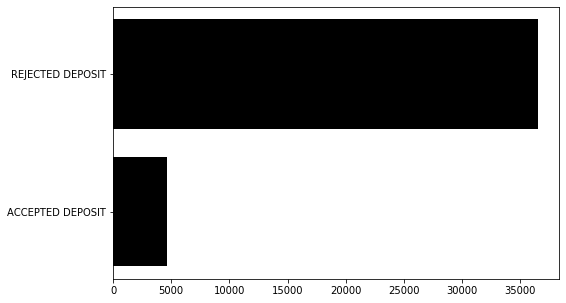

In [27]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 8, 5
plt.tight_layout()

positive_examples = y.sum()
negative_examples = len(y) - positive_examples
plt.barh(["ACCEPTED DEPOSIT", "REJECTED DEPOSIT"], [positive_examples, negative_examples], color = "k")
plt.show()

#### 4.1.1 Attempt at resolving this: Downsampling the majority class

- let number of examples for minority class = `n`
- randomly choose `n` examples from the majority class
- create the new working dataset from these two set of examples

Note:  _An alternative to this approach is using a weighted approach. Negative responses will be assigned a lower weight while the positive responses will be assigned a higher weight to counter their effect during training and on performance metrics_

In [28]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state = 1)
X, Y = sampler.fit_resample(df_encoded, y)

In [29]:
print(X.shape, Y.shape)
print(type(X), type(Y))

(9282, 58) (9282,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


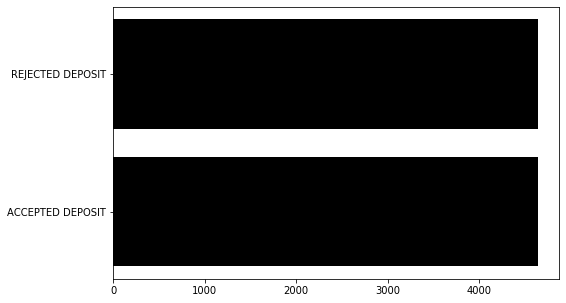

In [30]:
positive_examples = np.sum(Y)
negative_examples = np.sum(~np.array(Y, dtype = bool))
plt.barh(["ACCEPTED DEPOSIT", "REJECTED DEPOSIT"], [positive_examples, negative_examples], color = "k")
plt.show()

### 4.2 Train-Validate-Test split

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 20/100, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 8/20, random_state = 1)

In [32]:
y_train.shape, y_val.shape, y_test.shape

((7425,), (1114,), (743,))

In [33]:
x_train.shape, x_val.shape, x_test.shape

((7425, 58), (1114, 58), (743, 58))

### 4.3 Min-Max Feature Scaling

I will perform min-max feature scaling for every numeric variable in the three subsets

In [34]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
x_train = train_scaler.fit_transform(x_train)

val_scaler = MinMaxScaler()
x_val = val_scaler.fit_transform(x_val)

test_scaler = MinMaxScaler()
x_test = val_scaler.fit_transform(x_test)

## 5 Dumping records in `TFRecord` files

### 5.1 Initializing a dictionary of necessary hyperparameters

In [35]:
FLAGS = dict(tensorboard_data_dump = "./tensorboard_data_dump/",
             number_of_features = x_train.shape[1],
             batch_size = 64,
             validation_batch_size = x_val.shape[0],
             test_batch_size = x_test.shape[0],
             num_parallel_calls = 3,
             shuffle_buffer = 64,
             prefetch_buffer = 3,
             epochs = 100,
             learning_rate = 1e-4)

In [36]:
FLAGS

{'tensorboard_data_dump': './tensorboard_data_dump/',
 'number_of_features': 58,
 'batch_size': 64,
 'validation_batch_size': 1114,
 'test_batch_size': 743,
 'num_parallel_calls': 3,
 'shuffle_buffer': 64,
 'prefetch_buffer': 3,
 'epochs': 100,
 'learning_rate': 0.0001}

### 5.2 Creating tfRecord dump directories

In [37]:
!mkdir -p "train_tfrecords"
!mkdir -p "test_tfrecords"
!mkdir -p "val_tfrecords"

In [38]:
train_dump = "./train_tfrecords/"
test_dump = "./test_tfrecords/"
val_dump = "./val_tfrecords/"

### Defining a function to dump a batched subset of a dataset

- `x_subset` = subset (sliced) `numpy.ndarray`
 - _`x_subset` is expected to be a matrix in the context of this project_
 
- `y_subset` = subset (sliced) `numpy.ndarray`
 - _`y_subset` is expected to be a vector with the same number of rows as that of `x_subset`_
 
- `writer` =  An instance of `tf.python_io.TFRecordWriter` which has been initialized with a dump directory path. 

<br>

***How does the dumping work?***

- Initialize a writer object `writer`
- Convert all your dump data to lists (because the dumper only works with lists)
 - Since our numpy array is essentially a form of nested list, I need to extract each row(sub-list) from the nested list and then pass it to `tf.train.Feature`
- Create a `tf.train.Feature` object out of each wrapped-up data variable seperately. Use the appropiate argument name: `float_list`, `int32_list`, `int64_list`
- Create a native `dict` out of the `tf.train.Feature` instances by associating a key with each of them. This `dict` will now serve as a schema of storage and retrieval for each feature-label pair.
- Wrap the `dict` in a `tf.train.Example`. In essence, each row in the dataset is now a single `Example` object to be fed into a Tensorflow Data-Flow Graph.


***Why do we do this?***

- Need for speed
- Setting a highly-parallelized, optimized and efficient pipeline for flow of data

In [39]:
def dump_into_tf_record_file(x, y, writer):
    data = x.tolist()
    label = y
    data = tf.train.Feature(float_list = tf.train.FloatList(value = data))
    label = tf.train.Feature(float_list = tf.train.FloatList(value = [label]))
    feature_dict = {"features":data, "label":label}
    feature_dict = tf.train.Features(feature = feature_dict)
    example = tf.train.Example(features = feature_dict)
    writer.write(example.SerializeToString())

### 5.3 Defining a function to dump a dataset as tfRecord files in a specified directory

- `dataset` = the `numpy.ndarray` of feature matrix to be dumped
- `labels` = the `numpy.ndarray` vector of output/target/response variable for `dataset`
- `dump_directory` = path to the local directory where the tfRecord files will be dumped
- `batch_size` = how many rows of `dataset` and `labels` will be there in each tfRecord file

The function will accept a dataset matrix and a label vector, divide it up by the batch size specified and then write each row of the dataset matrix and single label value associated with it in a `tfrecord` dump file.

In [40]:
def dump_dataset_into_tf_records(dataset, labels, dump_directory, batch_size):
    m = dataset.shape[0]
    i = 0
    j = 0
    writer = None
    while(i < m):
        if i % batch_size == 0:
            if writer is not None:
                writer.close()
            j = j + 1
            record_file_name = dump_directory  + "Batch_" + str(j) + ".tfrecord"
            writer = tf.python_io.TFRecordWriter(record_file_name)
        x = dataset[i, :]
        y = labels[i]
        dump_into_tf_record_file(x, y, writer)
        i = i + 1

### 5.4 Dump `x_train` and `y_train` at `./train_tfrecords`

In [41]:
!rm -rf $train_dump/*
dump_dataset_into_tf_records(x_train, y_train, train_dump, 500)

### 5.5 Dump `x_val` and `y_val` at `./val_tfrecords`

In [42]:
!rm -rf $val_dump/*
dump_dataset_into_tf_records(x_val, y_val, val_dump, 500)

### 5.6 Dump `x_test` and `y_test` at `./test_tfrecords`

In [43]:
!rm -rf $test_dump/*
dump_dataset_into_tf_records(x_test, y_test, test_dump, 500)

## 5.7 Creating Input Pipeline using tfRecords

### 5.7.1 Defining a function to retrive the tfRecord files from a directory in an efficient sequential manner

- Create an object of `tf.data.Dataset` by passing a list of the `tfrecord` files in the specified dump directory path
- Convert each `tf.train.Example` object as it is read from the `tfrecord` files back into the `feature_dict` format we specified before: `{"features":data, "label":label}`. This is done using the `tf.data.Dataset.map` method.
- To enhance the convertion from `Example` object to the `feature_dict` format, I specified an additional argument of `num_parallel_calls` = 3 (as specified previously in `FLAGS["num_parallel_calls"]`). Each conversion is independent of each other and hence this will allow to parallely convert 3 `Example` objects to `feature_dict` format.
- I also chose to shuffle the dataset during the retrieval pipeline and perform an indefinite random repeat of the data. This makes sure my model has no problem of "finishing" up the data flow.
- To further enhance the performance of the training process, I used `tf.train.Dataset.prefetch` method to set how many `tf.train.Example` objects will be fetched before it's turn has arrived to be fed into the Data-Flow graph

(__Note__)

This method (or more technically speaking, the pipeline construction on `tf.data.Dataset`) is most prone to bugs during implementation. This method defines how the `tensorflow` graph will receive data and how it will be trained (epochs and mini-batches per epoch). I spent 2 weeks trying to debug various errors like `OutOfRange`, `labels are []`, `NextIterator:0 End of sequence`. Here are some precautionary steps I took to debug them all, with the help of my instructor Artem:

1. `shuffle` must come before `batch`
2. Based on how many epochs and how many mini-batches you will have during training, please set your `batch_size` and `prefetch_buffer` accordingly
3. You would want your validation data to be the whole thing as 1 batch only. Then, don't perform `prefetch`.
4. The same (3) should follow for your testing data.
5. If you want to perform batched validation and testing on your model, set up your validation and testing pipeline accordingly.

In [44]:
from os import listdir

def get_dataset(directory,
                type_of_dataset,
                batch_size, 
                shuffle_size = FLAGS["shuffle_buffer"], 
                buffer_size = FLAGS["prefetch_buffer"]):
    
    record_file_names = [directory + file_name for file_name in listdir(directory)]
    dataset = tf.data.TFRecordDataset(record_file_names)
    dataset = dataset.map(parse_record, num_parallel_calls = FLAGS["num_parallel_calls"])
    
    # error: data shape becomes [1, 1] instead of [FLAGS["batch_size"], 1]
    # solution offered by Artem on 26 September 2019 1427 hours IST: order of op: shuffle, batch
    if type_of_dataset.upper() == "TRAINING":
        dataset = dataset.shuffle(buffer_size = shuffle_size)
    
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    # error: validation and test data are 1 batch only so no need to prefect for them
    # solution found by myself on 27 September 2019 Late Midnight IST
    if type_of_dataset.upper() == "TRAINING":
        dataset = dataset.prefetch(buffer_size = buffer_size)    
    else:
        dataset = dataset.prefetch(buffer_size = 1)   
    return(dataset)

### 5.7.2 Defining a function to parse each `tf.train.Example` from the tfRecord files

In [45]:
def parse_record(serialized_record):
    features_dict = {"features":tf.FixedLenFeature([FLAGS["number_of_features"]], tf.float32),
                     "label":tf.FixedLenFeature([1], tf.float32)}
    parsed = tf.parse_single_example(serialized = serialized_record, features = features_dict)

    data = parsed["features"]
    label = parsed["label"]
    
    data = tf.cast(data, tf.float32)
    label = tf.cast(label, tf.int32)
    
    return((data, label))

## 6 Designing the DataFlow Graph and executing a session

### 6.1 Logical structure of the Data Flow Graph as an user-defined Python Class object

***Base Model Class***

- this class will define the weight matrices, the bias vectors and their corresponding initializers
- this class will most importantly define the feed-forward architecture of the fully-connected neural network
- I took inspiration from François Chollet's `keras` framework which serves as a high-level wrapper API for Tensorflow (as well as other backends) and decided to write this class as a wrapper for creating custom Data Flow Graphs in Tensorflow

<br>

- `FCNN` will be my base model class name
- the class will be initalizer with defining the weight and bias tensor initializers
- the class will have a method `add_weight_matrix` which will add a weight matrix to the FCNN. The order in which the method is called to add the weight matrix determines the hidden layer to which the weight matrix will be associated.
- similarly, the class have a method `add_bias_vector`
- the most important method of the class will be `forward_propagation` which creates the Data Flow graph using the defined weight and bias tensors and returns the graph generated till the last hidden layer and the classification output generated

***Justification for variable names used in `FCNN.forward_propagation`***

For $X =$ `x_subset` (a batch of features),
- linear model $z = X.W^T + B$
- actual hypothesis equation $h = g(z)$ where $g$ is a non-linear function. Some of the [desirable properties](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions) of $g$ are:
    - Non-linearity (this is what makes Neural Networks _universal function approximators_)
    - Continuously differentiable
    - Monotonic
    - Smooth with monotonic derivative
    - Identity approximation near Origin 
- For $g$ = ReLU, 
$\begin{equation}
g(z) = \begin{cases} 
            0, & \text{if}\ z \leq 0 \\
            z, & \text{if}\ z > 0
        \end{cases}
\end{equation}$
- $\hat{y}$ (pronounced `y-hat` or `y-cap`) $= g'(h)$ where $g'$ is a special activation function which gives the final desired output in a set domain.
    - For classification problems,
        - If it is a binary classification problem, $g'$ can be $\sigma$ where $\sigma(z) = \frac{1}{1 + e^{-z}}$ (most preferred)
        - If it is a multi-class classification problem where each of the classes are mutually exclusive, $g'$ can be the softmax function where $g'(z) = \frac{e^z_i}{\sum\limits_{j=1}^J {e^{z_j}}}$ where $J = $ number of output classes the solution requires
    - For regression problems, a linear function with the desirable output domain will do the job. ( _provided the input has been normalized_ )

<br>

`forward_propagation` returns $h$ and $\hat{y}$ which are also called `logits` and `prediction` in `tensorflow` vocabulary.

In [46]:
class FCNN:
    
    def __init__(self, 
                 weight_initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.25),
                 bias_initializer = tf.zeros_initializer()):
        self.weight_initializer = weight_initializer
        self.bias_initializer = bias_initializer
        self.weights = []
        self.biases = []
    
    def add_weight_matrix(self, 
                          shape, 
                          scope_name = "WEIGHTS", 
                          dtype = tf.float32):
        
        with tf.name_scope(scope_name):
            i = len(self.weights)                                              
            self.weights.append(tf.get_variable(name = "W" + str(i),
                                                shape = shape, 
                                                dtype = dtype,
                                                initializer = self.weight_initializer))
    
    def add_bias_vector(self, 
                        shape, 
                        scope_name = "BIASES", 
                        dtype = tf.float32):
        
        with tf.name_scope(scope_name):
            i = len(self.biases)
            self.biases.append(tf.get_variable(name = "B" + str(i),
                                               shape = shape,
                                               dtype = dtype,
                                               initializer = self.bias_initializer))
    
    def forward_propagation(self, 
                            x_subset, 
                            output_activation_function = tf.nn.softmax, 
                            scope_name = "FEED_FORWARD_PROPAGATION"):
        
        with tf.name_scope(scope_name):
            x = x_subset
            for i in range(len(self.biases)):
                z = tf.matmul(x, self.weights[i]) + self.biases[i]
                h = tf.nn.relu(z)
                x = h
            h = tf.matmul(x, self.weights[-1], name = "LOGITS")
            yhat = output_activation_function(h, name = "SOFMAX_PREDICTION_FROM_LOGITS")
            return((h, yhat))

***Train Model Class***

- this class will be a child of `FCNN`
- this class will contain methods to define the loss function and  compute the loss incured by the Neural Network (FCNN instance)
- the most important method of this child class will be to define the back propagation of loss gradients

In [47]:
class myModel(FCNN):
    
    def __init__(self, batch_size, learning_rate):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        super(myModel, self).__init__()
    
    def compute_loss_incured(self, 
                             y_subset, 
                             h, 
                             loss_function = tf.nn.sparse_softmax_cross_entropy_with_logits, 
                             scope_name = "LOSS", 
                             add_penalty = True):
        
        with tf.name_scope(scope_name):
            
            # because dimensions of y_subset are (FLAGS["batch_size"], 1)
            labels = tf.squeeze(y_subset)

            cross_entropy = loss_function(labels = labels, 
                                          logits = h, 
                                          name = "CROSS_ENTROPY_LOSS")
            loss = tf.reduce_mean(cross_entropy, name = "AVERAGE_CROSS_ENTROPY_LOSS")
            
            if add_penalty:
                l2_loss = tf.add_n([tf.nn.l2_loss(T) for T in tf.trainable_variables()])
                loss = loss + self.learning_rate * l2_loss
        
        return(loss)
    
    def compute_naive_accuracy(self, 
                               x_subset, 
                               y_subset, 
                               scope_name = "NAIVE_ACCURACY"):
        
        with tf.name_scope(scope_name):
            _, yhat = self.forward_propagation(x_subset)
            
            # because dimensions of y_subset are (FLAGS["batch_size"], 1)
            labels = tf.squeeze(y_subset)

            # because when tf.argmax(axis = 1) will return column IDs as integers
            labels = tf.cast(labels, tf.int64)

            '''
            yhat is a matrix of dimensions (FLAGS["batch_size"], number of classes = 2).
            labels will be a vector of length = FLAGS["batch_size]

            Using tf.argmax on yhat along the row axis(axis = 1), we find the column which has the
            maximum softmax probability, For the first column, ID will be 0. For the second, it will
            be 1. Incidentally, labels are also binary.

            Hence, class_ID_predicted should have dtype = an int type.

            Possible question: Are you sure the predictions mean what they should, after 
            applying tf.argmax?
            '''
            class_ID_predicted = tf.argmax(yhat, axis = 1)

            # row-wise comparision of equality like xnor
            is_each_predicted_class_ID_correct = tf.equal(class_ID_predicted, labels)
            
            # to compute the accuracy using tf.reduce_mean, the values now need to be in a float type
            is_each_predicted_class_ID_correct = tf.cast(is_each_predicted_class_ID_correct, tf.float32)

            # add the values in is_each_predicted_class_ID_correct and divide by the length of the same
            accuracy = tf.reduce_mean(is_each_predicted_class_ID_correct)
        
        return(accuracy)
    
    def backward_propagation(self, 
                             loss, 
                             scope_name = "BACKWARD_PROPAGATION"):
        
        with tf.name_scope(scope_name):
            trainable_variables = tf.trainable_variables()
            gradients = tf.gradients(loss, trainable_variables, name = "dL")
            optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate, name = "Min_dL")
            
            '''
            Exact Live Documentation on how apply_gradients can be found at this link:
            https://github.com/tensorflow/tensorflow/blob/r1.14/tensorflow/python/training/optimizer.py#L531-L637

            '''
            update_operation = optimizer.apply_gradients(grads_and_vars = zip(gradients, trainable_variables),
                                                         name = "dL_update")
        
        return(update_operation)

<br>
<br>

***Performance Evaluation Metrics***

- Recall
- Precision
- F1 score
- AUC

In [48]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def evaluate_model(y_subset, yhat, pos_label_scores, interpretations_of_labels = None, complete = True):    
    if complete:
        print(classification_report(y_true = y_subset,
                                    y_pred = yhat,
                                    target_names = interpretations_of_labels,
                                    digits = 2))
    else:
        tn, fp, fn, tp = confusion_matrix(y_subset, yhat).ravel() 
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        auc = roc_auc_score(y_subset, pos_label_scores)
        
        print('Precision: %0.02f%% '% (precision * 100))
        print('Recall: %0.02f%% '% (recall * 100))
        print('F1 score: %0.02f%% '% (f1 * 100))
        print('AUC: %0.02f%%' % (auc * 100))

### 6.2 Defining Session Protocols

In [49]:
config = tf.ConfigProto(log_device_placement = True)
config.gpu_options.allow_growth = False

### 6.3 Create  the DataFlow Graph

In [50]:
G = tf.Graph()

with G.as_default():
    
    with tf.name_scope("INPUT_PIPELINE"):
        
        train = get_dataset(train_dump, 
                            batch_size = FLAGS["batch_size"], 
                            type_of_dataset = "TRAINING")
        validation = get_dataset(val_dump,
                                 batch_size = FLAGS["validation_batch_size"],
                                 type_of_dataset = "VALIDATION")
        test = get_dataset(test_dump, 
                           batch_size = FLAGS["test_batch_size"], 
                           type_of_dataset = "TESTING")
        
        train_iterator = train.make_initializable_iterator()
        test_iterator = test.make_initializable_iterator()
        val_iterator = validation.make_initializable_iterator()
        
        x_train_subset, y_train_subset = train_iterator.get_next()
        x_val_subset, y_val_subset = val_iterator.get_next()
        x_test_subset, y_test_subset = test_iterator.get_next()

        '''
        We need to have a copy of x_train_subset and y_train_subset before moving to create the dataflow
        graph. Since they are iterators, having performed one forward pass, the variables will be empty
        by the time we need to compute the training accuracy and loss.
        '''
        x_train_subset_copy, y_train_subset_copy = tf.identity(x_train_subset), tf.identity(y_train_subset)
    
    model = myModel(FLAGS["batch_size"], FLAGS["learning_rate"])
    
    # H1
    model.add_weight_matrix(shape = [FLAGS["number_of_features"], 128])
    model.add_bias_vector(shape = [128])
    
    # H2
    model.add_weight_matrix(shape = [128, 256])
    model.add_bias_vector(shape = [256])
    
    # H3
    model.add_weight_matrix(shape = [256, 128])
    model.add_bias_vector(shape = [128])
        
    # H4
    model.add_weight_matrix(shape = [128, 32])
    model.add_bias_vector(shape = [32])
    
    # H5
    model.add_weight_matrix(shape = [32, 2])
    
    # perform one forward pass
    h, _ = model.forward_propagation(x_subset = x_train_subset)
    
    # compute loss after one forward pass
    loss = model.compute_loss_incured(y_subset = y_train_subset,
                                      h = h)
    loss_summary = tf.summary.scalar(name = "LOSS", tensor = loss)
    
    # based on loss incured, perform backprop
    update_operation = model.backward_propagation(loss = loss)
    
    # peri-training metrics
    train_accuracy = model.compute_naive_accuracy(x_subset = x_train_subset_copy, y_subset = y_train_subset_copy)
    train_accuracy_summary = tf.summary.scalar(name = "TRAIN_ACCURACY", tensor = train_accuracy)
    validation_accuracy = model.compute_naive_accuracy(x_subset = x_val_subset, y_subset = y_val_subset)
    validation_accuracy_summary = tf.summary.scalar(name = "VALIDATION_ACCURACY", tensor = validation_accuracy)
    
    # for testing
    _, predictions = model.forward_propagation(x_subset = x_test_subset)
    
    # collecting all the summary objects during training in one operation
    merged_summaries = tf.summary.merge([loss_summary, train_accuracy_summary])
    
    # node to dump the model
    saver = tf.train.Saver()

    
#clear up any deprecation warnings if there
clear_output()
    
number_of_batches = x_train.shape[0]//FLAGS["batch_size"]

print("Training Batch Size = %i, so number of mini-batches for each epoch = %i" % (FLAGS["batch_size"], number_of_batches))

print("After forward propagation, shape of h (logits) = ", h.shape)

print("Shape of INPUT FEATURES (train, validation, test) = ", 
      x_train_subset.shape, 
      x_val_subset.shape, 
      x_test_subset.shape)

print("Shape of GROUND TRUTH LABEL (train, validation, test) = ",
      y_train_subset.shape, 
      y_val_subset.shape, 
      y_test_subset.shape)

Training Batch Size = 64, so number of mini-batches for each epoch = 116
After forward propagation, shape of h (logits) =  (?, 2)
Shape of INPUT FEATURES (train, validation, test) =  (?, 58) (?, 58) (?, 58)
Shape of GROUND TRUTH LABEL (train, validation, test) =  (?, 1) (?, 1) (?, 1)


### 6.4 Visualize the DataFlow Graph Inline

[Source code from Tensorflow Authors](https://nbviewer.jupyter.org/github/tensorflow/examples/blob/master/community/en/r1/deepdream.ipynb#Loading-and-displaying-the-model-graph)

In [51]:
from IPython.display import Image, display, HTML

def strip_consts(graph_def, max_const_size = 32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size = 32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:950px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [52]:
show_graph(G)

### 6.5 Execute a session on `G`

In [53]:
# if you require you may uncomment this line to load the tensorboard command for Juypyter

#%load_ext tensorboard

In [54]:
tf.reset_default_graph()

# `writer` will dump the summary data during training/validation which
# will be read and visualized by tensorboard
temp = FLAGS["tensorboard_data_dump"]
writer = tf.summary.FileWriter(temp)

!rm -rf $temp/*
!mkdir -p "trained_model_dumps"
!rm -rf $trained_model_dumps/*.ckpt

# if you require you may uncomment this line to launch the tensorboard inline
#%tensorboard --logdir {temp}

loss_history = []
train_accuracy_history = []
validation_accuracy_history = []

with tf.Session(graph = G, config = config) as session:
    
    # initialize all `tf.Variables` declared in the graph
    session.run(tf.global_variables_initializer())
    
    print(" (Training)\n")
    print(" A - Training Accuracy\n L - Training Loss\n VA = Validation Accuracy\n\n")
    
    # I wanted to visualize the graph in tensorboard too
    writer.add_graph(G)
    
    for i in range(FLAGS["epochs"]):
        
        # you will need to start the iterator so that they are ready to
        # flow-transfer data into the graph
        session.run(train_iterator.initializer)
        session.run(val_iterator.initializer)
        
        temp_loss = 0
        temp_accuracy = 0
        
        for j in range(number_of_batches):

            # compute the loss by executing the loss sub-graph
            L = session.run(loss)
            
            # perform backprop on the whole graph G
            session.run(update_operation)
            
            # compute the training accuracy now the graph has been trained once
            A = session.run(train_accuracy)
            
            # obtain a live summary object containing data dumps for the summary objects declared
            # in conjunction with the graph G
            summary = session.run(merged_summaries)
        
            temp_loss = temp_loss + L
            temp_accuracy = temp_accuracy + A
            
            # dump the current summary object and mark it with iteration id = k
            # here, k = the iteration number/step -after- i epochs and j mini-batches of training
            k = (i + 1) * FLAGS["epochs"] + (j + 1)
            writer.add_summary(summary, k)
        
        # compute the validation accuracy by running the validation accuracy sub-graph after one epoch
        temp_validation_accuracy = session.run(validation_accuracy)
        
        # ought to add the summary collected for the validation accuracy data
        summary = session.run(validation_accuracy_summary)
        writer.add_summary(summary, k)        
        
        # compute the average loss and average accuracy after each epoch
        temp_loss = temp_loss/number_of_batches
        temp_accuracy = temp_accuracy/number_of_batches
        
        # record loss, train accuracy and validation accuracy so that we plot some graphs
        loss_history.append(temp_loss)
        train_accuracy_history.append(temp_accuracy)
        validation_accuracy_history.append(temp_validation_accuracy)
        
        print(" Epoch %i:\tA = %0.02f%%\tL = %0.04f\tVA = %0.02f%%" % ((i + 1), 
                                                                    temp_accuracy * 100, 
                                                                    temp_loss, 
                                                                    temp_validation_accuracy * 100))
        
        # make sure the any pending dumping work on the summary writer object is cleared
        writer.flush()
        
    # the training is complete, so now we can close the open write stream associated
    writer.close()
    
    # since we will be exiting our session after training, we ought to save all data associated with the session offline
    model_dump_path = "./trained_model_dumps/myModel_with_VA_" + str(int(temp_validation_accuracy * 100)) + "_percent.ckpt"
    saver.save(session, model_dump_path)

 (Training)

 A - Training Accuracy
 L - Training Loss
 VA = Validation Accuracy


 Epoch 1:	A = 58.27%	L = 2.2824	VA = 63.11%
 Epoch 2:	A = 64.57%	L = 1.3755	VA = 65.44%
 Epoch 3:	A = 66.69%	L = 1.1328	VA = 67.06%
 Epoch 4:	A = 69.17%	L = 0.9986	VA = 69.48%
 Epoch 5:	A = 71.19%	L = 0.9291	VA = 70.65%
 Epoch 6:	A = 73.37%	L = 0.8745	VA = 71.27%
 Epoch 7:	A = 74.14%	L = 0.8214	VA = 72.53%
 Epoch 8:	A = 75.51%	L = 0.8030	VA = 72.71%
 Epoch 9:	A = 77.44%	L = 0.7778	VA = 73.25%
 Epoch 10:	A = 77.87%	L = 0.7410	VA = 73.52%
 Epoch 11:	A = 79.51%	L = 0.7105	VA = 74.87%
 Epoch 12:	A = 79.96%	L = 0.7035	VA = 75.22%
 Epoch 13:	A = 81.36%	L = 0.6815	VA = 75.58%
 Epoch 14:	A = 81.26%	L = 0.6560	VA = 76.03%
 Epoch 15:	A = 82.61%	L = 0.6524	VA = 76.30%
 Epoch 16:	A = 83.31%	L = 0.6269	VA = 77.47%
 Epoch 17:	A = 83.28%	L = 0.6258	VA = 76.57%
 Epoch 18:	A = 84.38%	L = 0.5970	VA = 77.65%
 Epoch 19:	A = 84.63%	L = 0.5981	VA = 78.55%
 Epoch 20:	A = 85.64%	L = 0.5731	VA = 77.92%
 Epoch 21:	A = 86.06%	L = 

### 6.5 Visualize loss, train accuracy and validation accuracy

#### 6.5.1 In `matplotlib`

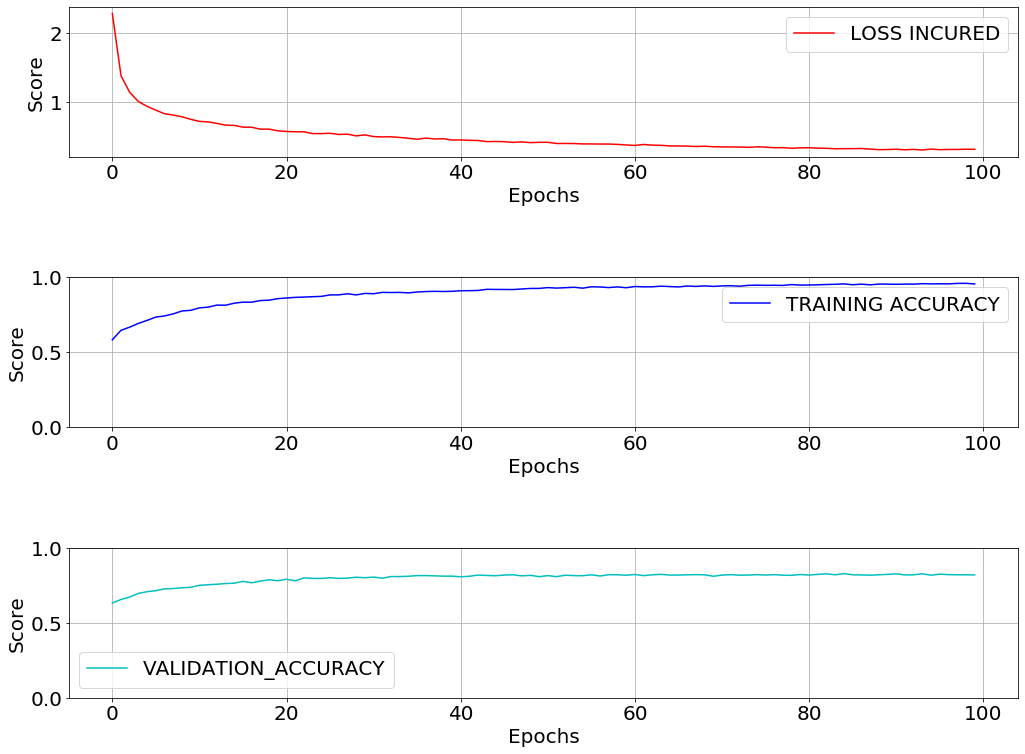

In [55]:
plt.rcParams['figure.figsize'] = 17, 12
plt.rcParams.update({'font.size': 20})
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.8, hspace = 0.8)

t = np.arange(len(train_accuracy_history))

plt.subplot(3, 1, 1)
plt.plot(t, loss_history, "r", label = "LOSS INCURED")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, train_accuracy_history, "b", label = "TRAINING ACCURACY")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.legend()
plt.grid()

t = np.arange(len(validation_accuracy_history))

plt.subplot(3, 1, 3)
plt.plot(t, validation_accuracy_history, "c", label = "VALIDATION_ACCURACY")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.legend()
plt.grid()

plt.show()

#### 6.5.2 In `tensorboard`

##### LOSS

<img src = "./tensorboard_plots/LOSS_1.svg" width = 750 height = 500 align = "left">

##### TRAINING ACCURACY

<img src = "./tensorboard_plots/TRAIN_ACCURACY.svg" width = 750 height = 500 align = "left">

##### VALIDATION ACCURACY

<img src = "./tensorboard_plots/VALIDATION_ACCURACY.svg" width = 750 height = 500 align = "left">

### 6.7 Test the trained model `G` and compute evaluation metrics

In [56]:
with tf.Session(graph = G) as session:
    
    # let's load our saved session data
    saver.restore(session, model_dump_path)
    clear_output()
    
    print("(Evaluation)\n")
        
    # ought to start the iterator for test data flow
    session.run(test_iterator.initializer)
    
    # get the predictions and the ground truth used to generate that
    # Note:    don't run this in two session calls.
    # Reason:  performing a second run with `y_test_subset` will get you the next batch of data
    yhat, y = session.run([predictions, y_test_subset])
    
    # obtain the column with the highest softmax probability
    # that will be our actual binary prediction
    y_predictions = np.argmax(yhat, axis = 1)
    
    # we need the positive class probability to compute the AUC score
    positive_class_softmax_probability = yhat[:, 1]
    
    evaluate_model(y_test, 
                   y_predictions, 
                   positive_class_softmax_probability, 
                   interpretations_of_labels = ["WILL_NOT_SUBSCRIBE_TO_BANK_DEPOSIT", 
                                                "WILL_SUBSCRIBE_TO_BANK_DEPOSIT"],
                  complete = True)

(Evaluation)

                                    precision    recall  f1-score   support

WILL_NOT_SUBSCRIBE_TO_BANK_DEPOSIT       0.83      0.83      0.83       374
    WILL_SUBSCRIBE_TO_BANK_DEPOSIT       0.83      0.83      0.83       369

                          accuracy                           0.83       743
                         macro avg       0.83      0.83      0.83       743
                      weighted avg       0.83      0.83      0.83       743



In [57]:
# overall values
evaluate_model(y_test, 
               y_predictions, 
               positive_class_softmax_probability, 
               interpretations_of_labels = ["WILL_NOT_SUBSCRIBE_TO_BANK_DEPOSIT", 
                                            "WILL_SUBSCRIBE_TO_BANK_DEPOSIT"],
               complete = False)

Precision: 82.66% 
Recall: 82.66% 
F1 score: 82.66% 
AUC: 88.91%


(__Note__)

In case you wish to perform inference on such a model trained using the `tf.data` API, look up this [answer]( https://stackoverflow.com/questions/50940667/inference-with-a-model-trained-with-tf-dataset).